In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'viridis'

from PIL import Image
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
marker_list = ['o', 's', 'x', '^']
from inference import *

In [67]:
import os
import pandas as pd
import io  # Import the io module

# Directory containing the data files
data_dir = "./data/SNSNSE/"

# Initialize a list to store the data
snsnse_data = []

# Iterate through all files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):  # Assuming the files have a .csv extension
        filepath = os.path.join(data_dir, filename)
        
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # Extract Q value from the file
        q_line = next(line for line in lines if line.startswith("# q"))
        q_value = float(q_line.split(",")[1].strip())
        
        # Extract sample identifier from the filename (e.g., assuming filenames are like "sample1_data.csv")
        sample_id = filename.split("_")[0]
        
        # Filter out rows starting with '#'
        data_lines = [line for line in lines if not line.startswith("#")]
        
        # Read the data into a DataFrame
        data = pd.read_csv(io.StringIO("\n".join(data_lines)), names=["t", "I", "I_err"])
        data["Q"] = q_value  # Add Q value as a column
        data["Filename"] = filename  # Add filename as a column
        data["Sample"] = sample_id  # Add sample identifier as a column
        
        # Append the DataFrame to the list
        snsnse_data.append(data)

# Combine all data into a single DataFrame
snsnse_df_all = pd.concat(snsnse_data, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(snsnse_df_all.head())


          t         I     I_err        Q                 Filename   Sample
0  0.096006  0.971859  0.007352  0.06997  sample1_20c-q-0.070.csv  sample1
1  0.153088  0.981903  0.007537  0.06997  sample1_20c-q-0.070.csv  sample1
2  0.229072  0.960900  0.008480  0.06997  sample1_20c-q-0.070.csv  sample1
3  0.311147  0.966547  0.007116  0.06997  sample1_20c-q-0.070.csv  sample1
4  0.469349  0.951694  0.006329  0.06997  sample1_20c-q-0.070.csv  sample1


In [68]:
snsnse_df_all

,t,I,I_err,Q,Filename,Sample
0,0.096006,0.971859,0.007352,0.069970,sample1_20c-q-0.070.csv,sample1
1,0.153088,0.981903,0.007537,0.069970,sample1_20c-q-0.070.csv,sample1
2,0.229072,0.960900,0.008480,0.069970,sample1_20c-q-0.070.csv,sample1
3,0.311147,0.966547,0.007116,0.069970,sample1_20c-q-0.070.csv,sample1
4,0.469349,0.951694,0.006329,0.069970,sample1_20c-q-0.070.csv,sample1
...,...,...,...,...,...,...
428,1.153712,0.438291,0.009951,0.203694,sample2_20c-q-0.204.csv,sample2
429,1.486748,0.351751,0.006319,0.203694,sample2_20c-q-0.204.csv,sample2
430,2.288521,0.228808,0.010582,0.203694,sample2_20c-q-0.204.csv,sample2
431,2.951166,0.136598,0.006790,0.203694,sample2_20c-q-0.204.csv,sample2


## 20C

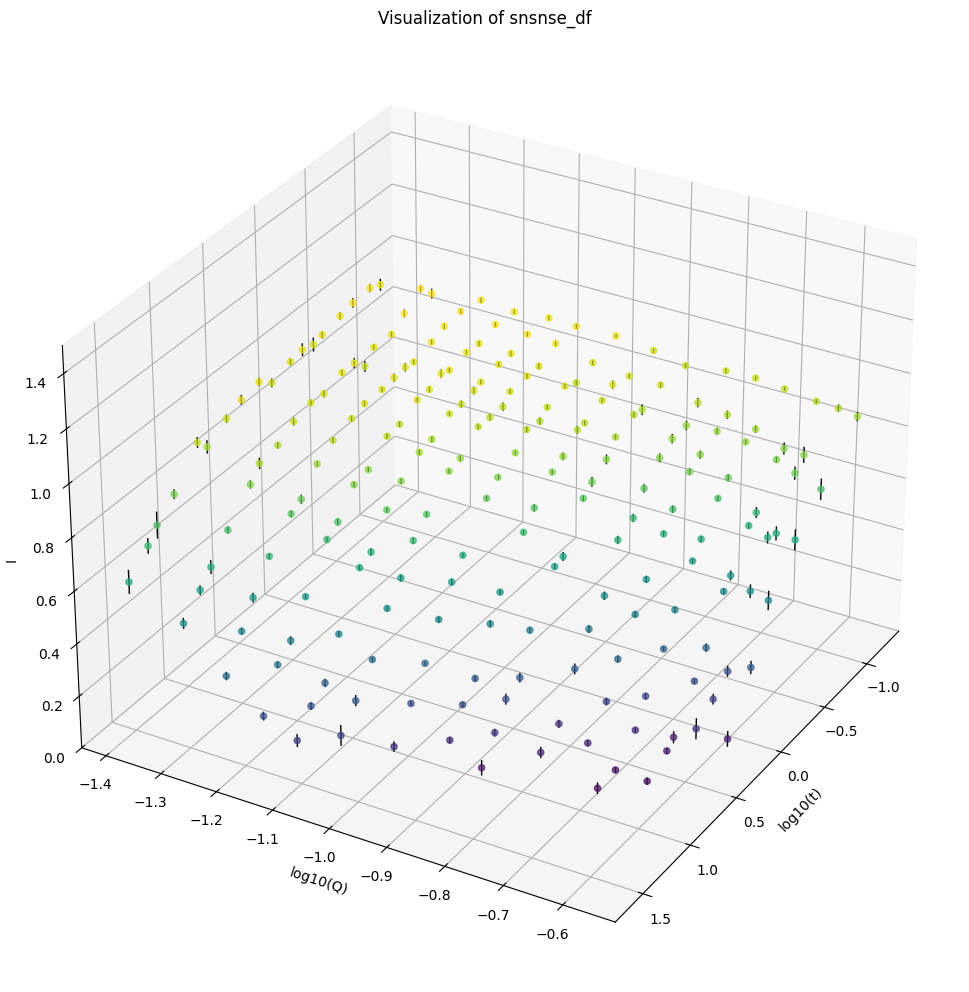

In [147]:
snsnse_df = snsnse_df_all[snsnse_df_all['Sample'] == 'sample1']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract data from snsnse_df
x = np.log10(snsnse_df['t'])
y = np.log10(snsnse_df['Q'])
z = snsnse_df['I']
zerr = snsnse_df['I_err']

# Scatter plot with error bars
sc = ax.scatter(x, y, z, c=z, cmap=cmap, alpha=0.7, vmax=1, vmin=0, marker='o')

# Add vertical error bars
for xi, yi, zi, ezi in zip(x, y, z, zerr):
    ax.plot([xi, xi], [yi, yi], [zi - ezi, zi + ezi], color='k', alpha=1, linewidth=1)

# Set plot properties
ax.view_init(elev=30, azim=30)
ax.set_zlim(0, 1.5)
ax.set_xlabel('log10(t)')
ax.set_ylabel('log10(Q)')
ax.set_zlabel('I', rotation=90)
ax.set_title('Visualization of snsnse_df')

plt.tight_layout(pad=1.0)

# Prepare concatenated lists
Q_flattened_list = [snsnse_df['Q'].values]
t_flattened_list = [snsnse_df['t'].values]
echo_flattened_list = [snsnse_df['I'].values]
echo_err_flattened_list = [snsnse_df['I_err'].values]
average_list = [snsnse_df['I'].values]
average_err_list = [snsnse_df['I_err'].values]

sqt_list = [np.concatenate(echo_flattened_list)]
sqt_err_list = [np.concatenate(echo_err_flattened_list)]
Q_flattened = np.concatenate(Q_flattened_list)
t_flattened = np.concatenate(t_flattened_list)
I_0_list = [np.concatenate(average_list, axis=0)]
I_0_err_list = [np.concatenate(average_err_list, axis=0)]


In [148]:
np.unique(Q_flattened_list)

array([0.04116717, 0.05113422, 0.06041239, 0.06996955, 0.07983096,
       0.0897859 , 0.1045016 , 0.1216004 , 0.137782  , 0.1610771 ,
       0.1810192 , 0.2031885 , 0.2298034 , 0.2489234 , 0.2679892 ])

L: 298, M: 818, N: 10


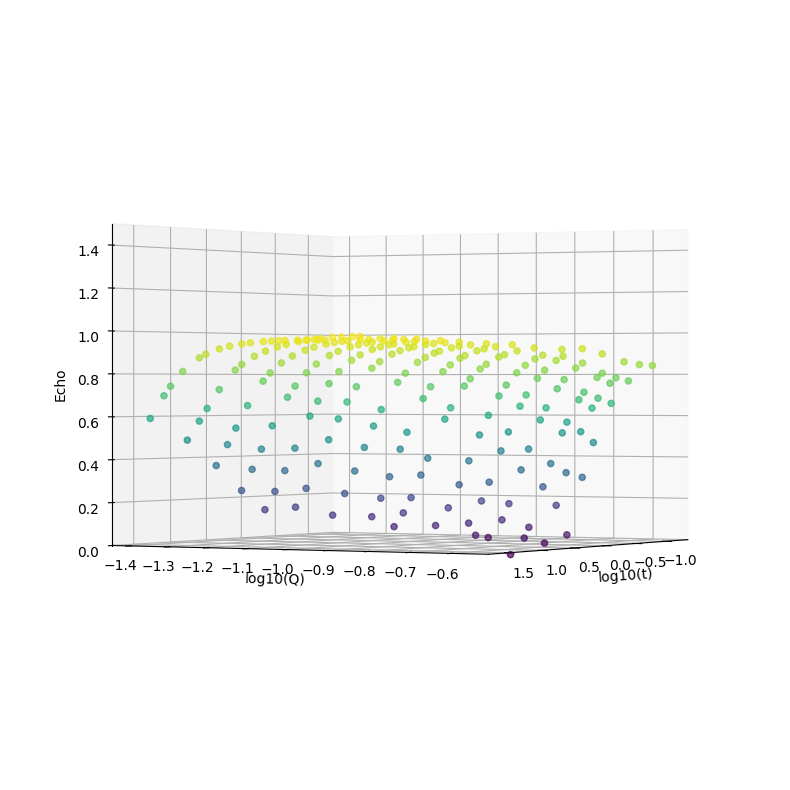

In [284]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(10, 10))
sqt_GPR_list = []
sqt_GPR_err_list = []
A_GPR_list = []

ax = fig.add_subplot(111, projection='3d')

sqt_exp = sqt_list[0]  # Assuming the first element of sqt_list is used
delta_sqt_exp = sqt_err_list[0]
Q_obs = Q_flattened
t_obs = t_flattened

# Append the observed data with known BCs
Q_unique = np.unique(Q_obs)
Q_app_grid, t_app_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min()), np.log10(Q_obs.max()), 30), np.logspace(1, 2, 20))
t_zero = np.exp(-np.logspace(0, np.log10(Q_obs.max()) - np.log10(Q_obs.min()), 30)) * 2e3
t_app_grid = t_app_grid * t_zero
Q_app = Q_app_grid.flatten()
t_app = t_app_grid.flatten()
sqt_exp_app = np.zeros_like(Q_app)
epsilon_app = 1e-3
delta_sqt_exp_app = np.ones_like(t_app) * epsilon_app
Q_obs_app = np.concatenate([Q_obs, Q_app])
t_obs_app = np.concatenate([t_obs, t_app])
sqt_exp_app = np.concatenate([sqt_exp, sqt_exp_app])
delta_sqt_exp_app = np.concatenate([delta_sqt_exp, delta_sqt_exp_app])

Q_eval_grid, t_eval_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min())*0.9, np.log10(Q_obs.max())*1.1, 40), np.logspace(-1.5, 2.5, 2))
Q_eval = Q_eval_grid.flatten()
t_eval = t_eval_grid.flatten()
Q_eval = np.concatenate([Q_obs, Q_eval])
t_eval = np.concatenate([t_obs, t_eval])

lambda_ = 0.14
mu_ = lambda_

N_Prony = 10
# Using a nonlinear spacing (quadratic in log-space)
log_tau = np.linspace(0.4, 2.2, N_Prony)
log_tau_dense = 0.4 + (2.2 - 0.4) * (np.linspace(0, 1, N_Prony) ** 4)
list_tau_i = 10 ** log_tau_dense
tau = np.array(list_tau_i)
bg_mode = False

A_GPR, K_GPR, sqt_GPR = bayesian_inference(
    sqt_exp_app, delta_sqt_exp_app, np.log(Q_obs_app), t_obs_app, np.log(Q_eval), t_eval, tau, mu_, lambda_, bg_mode=bg_mode, sigma_scale=0.15, prior_mean_scale=1.0, use_diffusivity_prior=False
)

sqt_GPR_obs = sqt_GPR[:len(sqt_exp)]
sqt_GPR_list.append(sqt_GPR_obs)
A_GPR_list.append(A_GPR)

ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR_obs, c=sqt_GPR_obs, alpha=0.7, vmax=1, vmin=0)

ax.view_init(elev=0, azim=30)
ax.set_zlim(0, 1.5)
ax.set_xlabel('log10(t)')
ax.set_ylabel('log10(Q)')
ax.set_zlabel('Echo', rotation=90)
ax.set_box_aspect(None, zoom=0.85)


In [285]:
Q_unique

array([0.04116717, 0.05113422, 0.06041239, 0.06996955, 0.07983096,
       0.0897859 , 0.1045016 , 0.1216004 , 0.137782  , 0.1610771 ,
       0.1810192 , 0.2031885 , 0.2298034 , 0.2489234 , 0.2679892 ])

In [286]:
# from scipy.optimize import curve_fit
# fig = plt.figure(figsize=(10, 10))
# for i, duration in enumerate(duration_list):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     axs.append(ax)
    
#     sqt_GPR = sqt_GPR_list[i]
#     sqt_exp = sqt_list[i]
#     sqt_exp_err = sqt_err_list[i]
#     # sqt_exp_err_lt 

    
#     ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR-sqt_exp_lt, c=sqt_GPR-sqt_exp_lt, alpha=1, vmax=0.5, vmin=-0.5, cmap="bwr")
#     # ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp-sqt_exp_lt, c='k', alpha=0.7, vmax=0.5, vmin=-0.5, cmap="bwr")
    
#     print(np.sqrt(np.mean(((sqt_GPR-sqt_exp_lt))**2)))

#     ax.view_init(elev=30, azim=30)
#     ax.set_zlim(-1, 1)
#     ax.set_xlabel('log10(t)')
#     ax.set_ylabel('log10(Q)')
#     ax.set_zlabel('Echo', rotation=90)
#     ax.set_box_aspect(None, zoom=0.85)
#     ax.set_title(f'Duration: {duration} s')
    
# plt.tight_layout(pad=1.0)

Q=0.04, tau=96.0013, beta=0.7636
Q=0.05, tau=57.9606, beta=0.7920
Q=0.06, tau=36.2030, beta=0.8471
Q=0.07, tau=25.3978, beta=0.8461
Q=0.08, tau=17.8794, beta=0.8533
Q=0.09, tau=13.3490, beta=0.8257
Q=0.10, tau=8.3282, beta=0.8630
Q=0.12, tau=5.5943, beta=0.9026
Q=0.14, tau=4.0253, beta=0.8352
Q=0.16, tau=2.4724, beta=0.8383
Q=0.18, tau=1.8696, beta=0.8788
Q=0.20, tau=1.3906, beta=0.8846
Q=0.23, tau=1.0122, beta=0.8830
Q=0.25, tau=0.8932, beta=0.8630
Q=0.27, tau=0.7230, beta=0.8465


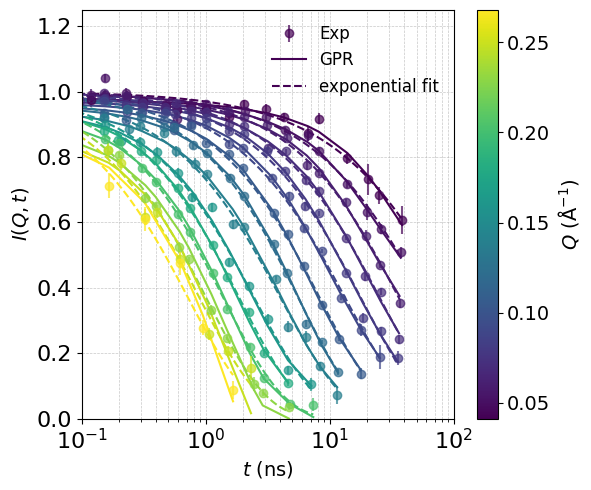

In [292]:
from scipy.optimize import curve_fit
import matplotlib.cm as cm  # Import cm from matplotlib
import matplotlib.pyplot as plt  # Ensure plt is imported

cmap = plt.get_cmap('viridis')  # Use plt.get_cmap instead of cm.get_cmap

# Define the stretched exponential function
def f_sexp(t, s0, tau, beta):
    return s0 * np.exp(-(t / tau) ** beta)

# Create a figure for the plots
fig, ax = plt.subplots(figsize=(6, 5))

# Loop through each unique Q value
unique_Q = np.unique(snsnse_df['Q'])
norm = matplotlib.colors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
for i_q, q in enumerate(unique_Q):
    # Filter the data for the current Q value
    mask = snsnse_df['Q'] == q
    t_filtered = snsnse_df.loc[mask, 't']
    I_filtered = snsnse_df.loc[mask, 'I']
    I_err_filtered = snsnse_df.loc[mask, 'I_err']

    # Fit the data to the stretched exponential function
    try:
        popt, _ = curve_fit(lambda t, tau, beta: f_sexp(t, 1, tau, beta), t_filtered, I_filtered, p0=[1, 1], maxfev=10000)
        tau_fit, beta_fit = popt
        print(f"Q={q:.2f}, tau={tau_fit:.4f}, beta={beta_fit:.4f}")

        # Generate fitted curve
        t_fine = np.logspace(np.log10(t_filtered.min()), np.log10(t_filtered.max()), 100)
        I_fitted = f_sexp(t_fine, 1, tau_fit, beta_fit)

        # Plot the data with error bars
        color = cmap(norm(q))
        label = ''
        if i_q == 0:
            label = 'Exp' 
        ax.errorbar(t_filtered, I_filtered, yerr=I_err_filtered, fmt='o', label=label, alpha=0.7, color=color)
        label = ''
        if i_q == 0:
            label = 'exponential fit' 
        ax.plot(t_fine, I_fitted, '--', color=color, label=label)
    except RuntimeError:
        print(f"Fit failed for Q={q:.2f}")

    # Overlay GPR predictions
    mask_gpr = Q_obs == q
    t_gpr = t_obs[mask_gpr]
    sqt_gpr = sqt_GPR_list[0][mask_gpr]  # Assuming the first element of sqt_GPR_list is used
    sqt_gpr[sqt_gpr < 0] = 1e-6  # Set GPR results less than 0 to 1e-6
    sqt_gpr_plot = sqt_gpr.copy()
    for i_s, s in enumerate(sqt_gpr_plot):
        if i_s > 0 and s >= sqt_gpr_plot[i_s - 1]:
            sqt_gpr_plot[i_s] = sqt_gpr_plot[i_s - 1] * 0.1
    label = ''
    if i_q == 0:
        label = 'GPR' 
    ax.plot(t_gpr, sqt_gpr_plot, '-', color=color, label=label)

# Set axis scales and labels
ax.set_xscale('log')
ax.set_xlabel(r'$t$ (ns)', fontsize=14)
ax.set_ylabel(r'$I(Q, t)$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.set_title('I(Q, t) vs t with Stretched Exponential Fits and GPR Predictions', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xlim(0.1, 100)
ax.set_ylim(0, 1.25)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, loc='upper right', frameon=False)
# Add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

In [259]:
sqt_gpr_plot

array([0.83958731, 0.77055961, 0.67061973, 0.49392483, 0.3325191 ,
       0.05066523])